<a href="https://colab.research.google.com/github/momo46060/ComposeMulitplatform/blob/master/Recommndtion_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

In [54]:
# Importing the dataset
movies = pd.read_csv('movies.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')
users = pd.read_csv('users.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')
ratings = pd.read_csv('ratings.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')



In [55]:
# Preparing the traning set and the test set
training_set = pd.read_csv('u1.base', delimiter = '\t')
training_set = np.array(training_set, dtype = 'int')
test_set = pd.read_csv('u1.test', delimiter = '\t')
test_set = np.array(test_set, dtype = 'int')


In [56]:
# Getting the number of users and movies
nb_users = int(max(max(training_set[:,0]), max(test_set[:,0])))
nb_movies = int(max(max(training_set[:,1]), max(test_set[:,1])))

In [57]:
# Convert the data into an array with users un lines and movies in columns
def convert(data):
    new_data = []
    for id_users in range(1, nb_users + 1 ):
        id_movies  = data[:,1][ data[:,0] == id_users]
        id_ratings = data[:,2][ data[:,0] == id_users]
        ratings = np.zeros(nb_movies)
        ratings[id_movies - 1] = id_ratings
        new_data.append(list(ratings))
    return new_data
training_set = convert(training_set)
test_set = convert(test_set)




In [58]:
# Converting the data into torch tensors
training_set = torch.FloatTensor(training_set)
test_set = torch.FloatTensor(test_set)
print (training_set)

tensor([[0., 3., 4.,  ..., 0., 0., 0.],
        [4., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [5., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 5., 0.,  ..., 0., 0., 0.]])


In [59]:
# Converting the ratings into binary ratings 1 (liked)  (not liked)
training_set[training_set == 0] = -1
training_set[training_set == 1] = 0
training_set[training_set == 2] = 0
training_set[training_set >= 3] = 1
test_set[test_set == 0] = -1
test_set[test_set == 1] = 0
test_set[test_set == 2] = 0
test_set[test_set >= 3] = 1


In [63]:
# Creating the architecture of the Nerual Network
class RBM():
    def __init__(self,nv,nh):
        self.W =torch.randn(nh,nv)
        self.a = torch.randn(1,nh)
        self.b = torch.randn(1,nv)
    def sample_h(self,x):
        wx = torch.mm(x,self.W.t())
        activation = wx +self.a.expand_as(wx)
        p_h_given_v = torch.sigmoid(activation)
        return p_h_given_v, torch.bernoulli(p_h_given_v)

    def sample_v(self,y):
        wy = torch.mm(y,self.W)
        activation = wy +self.b.expand_as(wy)
        p_v_given_h = torch.sigmoid(activation)
        return p_v_given_h, torch.bernoulli(p_v_given_h)
    def train(self,v0,vk,ph0,phk):
        # self.W += torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)
        self.W += torch.mm(ph0.t(), v0) - torch.mm(phk.t(), vk)
        self.b += torch.sum((v0 - vk),0)
        self.a += torch.sum((ph0 - phk),0)


In [64]:
nv = len(training_set[0])
nh = 100
batch_size = 100
rbm = RBM(nv,nh)

In [76]:
# Train the RBM
nb_epoch = 10
trainxloss=[]
for epoch in range(1, nb_epoch + 1):
    train_loss = 0
    s = 0.
    for id_user in range(0, nb_users - batch_size, batch_size):
        vk = training_set[id_user:id_user+batch_size]
        v0 = training_set[id_user:id_user+batch_size]
        ph0,_ = rbm.sample_h(v0)
        for k in range(10):
            _,hk = rbm.sample_h(vk)
            _,vk = rbm.sample_v(hk)
            vk[v0<0] = v0[v0<0]
        phk,_ = rbm.sample_h(vk)
        rbm.train(v0,vk,ph0,phk)
        train_loss += torch.mean(torch.abs(v0[v0>=0] - vk[v0>=0]))
        trainxloss.append(train_loss)
        s += 1.
    print('epoch: '+str(epoch)+' loss: '+str(train_loss/s))

epoch: 1 loss: tensor(0.2456)
epoch: 2 loss: tensor(0.2454)
epoch: 3 loss: tensor(0.2461)
epoch: 4 loss: tensor(0.2463)
epoch: 5 loss: tensor(0.2445)
epoch: 6 loss: tensor(0.2431)
epoch: 7 loss: tensor(0.2446)
epoch: 8 loss: tensor(0.2465)
epoch: 9 loss: tensor(0.2458)
epoch: 10 loss: tensor(0.2452)


In [77]:
# Testing the RBM
test_loss = 0
s = 0.
for id_user in range(nb_users):
    v = training_set[id_user:id_user+1]
    vt = test_set[id_user:id_user+1]
    if len(vt[vt >= 0]) > 0:
        _, h = rbm.sample_h(v)
        _, v_reconstructed = rbm.sample_v(h)
        test_loss += torch.mean(torch.abs(vt[vt >= 0] - v_reconstructed[vt >= 0]))
        s += 1.
print('test loss: ' + str(test_loss / s))

test loss: tensor(0.2568)


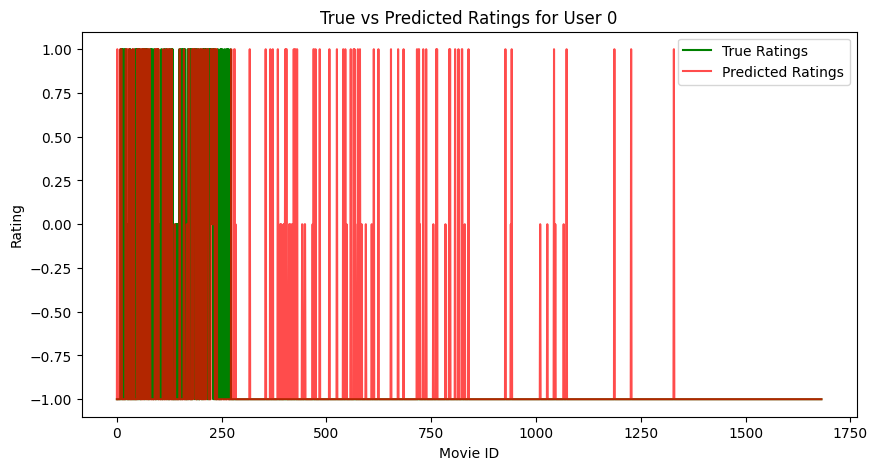

In [79]:
import matplotlib.pyplot as plt

# خذ عينة من المستخدم مثلاً
user_id = 0
v_real = test_set[user_id].numpy()
v_pred = v[user_id].detach().numpy()  # بعد ما تعمل prediction

plt.figure(figsize=(10,5))
plt.plot(v_real, label='True Ratings', color='g')
plt.plot(v_pred, label='Predicted Ratings', color='r', alpha=0.7)
plt.title('True vs Predicted Ratings for User {}'.format(user_id))
plt.xlabel('Movie ID')
plt.ylabel('Rating')
plt.legend()
plt.show()
